# Import

In [1]:
import os
import numpy as np

from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import lightkurve as lk
from astroquery.simbad import Simbad
import pandas as pd 
from numpy import genfromtxt
from sklearn.preprocessing import normalize

# #tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error



## Check GPU

In [2]:
devices = tf.config.list_physical_devices()
print(devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import Data

In [3]:
pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/Data_v3/0.csv',delimiter=',').to_numpy().shape

(122, 475)

In [21]:
all_data = np.empty((1,475))
for i in range(1609):
  try:
    all_data = np.concatenate((all_data,pd.read_csv('/Users/michaelsong/Documents/GitHub/starzam/Data_v3/'+str(i)+'.csv',delimiter=',').to_numpy()), axis=0)
  except:
    continue
all_data = all_data[1:].T[1:].T
print(all_data.shape)
# pd.read_csv('/content/drive/MyDrive/Research - Yihong Song and Rohit Prasanna/Yihong/Data_v2/0.csv',delimiter=',').to_numpy

(77197, 474)


In [22]:
print(all_data)
print(all_data.T[1])

[[7.57137000e+05 4.75100000e+03 2.38300000e+00 ... 5.85052317e+00
  9.69580351e+00 7.87920306e+00]
 [7.57137000e+05 4.75100000e+03 2.38300000e+00 ... 4.51275398e+00
  4.17921295e+00 5.35710573e+00]
 [7.57137000e+05 4.75100000e+03 2.38300000e+00 ... 2.39391900e+00
  3.23821209e+00 3.50633041e+00]
 ...
 [1.24553570e+07 4.63300000e+03 2.35500000e+00 ... 7.22105298e+00
  6.25722946e+00 6.97677380e+00]
 [1.24553570e+07 4.63300000e+03 2.35500000e+00 ... 5.24570461e+00
  6.56183340e+00 5.67633786e+00]
 [1.24553570e+07 4.63300000e+03 2.35500000e+00 ... 5.01127168e+00
  5.92280860e+00 4.84215917e+00]]
[4751. 4751. 4751. ... 4633. 4633. 4633.]


In [23]:
def isolate_observations(data):
    kic = 0
    res = np.empty((1,474))
    for i in range(len(data)):
        if(data[i][0]!=kic):
            kic = data[i][0]
            res = np.vstack((res,data[i]))
    return res

# iso_data = isolate_observations(all_data).T[:10].T
# print(iso_data)

In [24]:
def extract_xy(all_data):
    all_x = all_data.T[3:111].T
    all_y = all_data.T[1:3].T
    print(all_x.shape,all_y.shape)
    teff_y = all_y.T[0].T
    print(teff_y.shape)
    print(teff_y)
    print(all_x[1])
    return all_x,teff_y

all_x,teff_y = extract_xy(all_data)

(77197, 108) (77197, 2)
(77197,)
[4751. 4751. 4751. ... 4633. 4633. 4633.]
[1.         4.20230387 5.08429584 2.8705257  3.03384979 3.09656549
 3.75869284 3.02637558 3.31568472 3.41449566 3.89064309 4.46707678
 2.84617214 4.34024907 4.44872399 5.03072533 2.98603345 3.9704044
 4.04709734 2.80572554 2.4993625  2.28989815 2.79916182 3.17560122
 2.09595172 1.70385558 2.22020202 1.28954937 1.33034144 1.36817343
 1.44803374 1.22482013 1.17279956 1.15741269 1.02777875 0.83268147
 1.07621558 1.01634899 1.04705778 0.75180739 0.98345645 0.52860498
 0.64266898 0.91150894 0.64917226 0.72432438 0.53779949 0.42462443
 0.3537338  0.4926552  0.78995761 0.55776332 0.57220055 0.57275563
 0.49731549 0.43799971 0.4458369  0.45464592 0.62300697 0.3417187
 0.4578065  0.49357301 0.48549321 0.46430902 0.59852467 0.39175011
 0.46451555 0.35469993 0.4856069  0.31489359 0.29580494 0.37052073
 0.34718435 0.3317955  0.37470149 0.33784652 0.34154617 0.28003836
 0.34905947 0.35260452 0.31909339 0.28457844 0.3655531  

In [25]:
def normalize_with_moments(X_train, axes=0, epsilon=1e-8,keep_dims=True):
    x = tf.convert_to_tensor(X_train)
    mean, variance = tf.nn.moments(x, axes=axes)
    x_normed = (x - mean) / tf.sqrt(variance + epsilon) # epsilon to avoid dividing by zero
    return x_normed

def normalize_x(x):
    x = x.T
    for i in range(len(x)):
        x[i] = x[i] / np.linalg.norm(x[i])
    return x.T

In [26]:
# teff_y = normalize_with_moments(teff_y).numpy()
# all_x = normalize_x(all_x)
# print(teff_y)
# print(all_x)

In [27]:
print(all_x[1])

[1.         4.20230387 5.08429584 2.8705257  3.03384979 3.09656549
 3.75869284 3.02637558 3.31568472 3.41449566 3.89064309 4.46707678
 2.84617214 4.34024907 4.44872399 5.03072533 2.98603345 3.9704044
 4.04709734 2.80572554 2.4993625  2.28989815 2.79916182 3.17560122
 2.09595172 1.70385558 2.22020202 1.28954937 1.33034144 1.36817343
 1.44803374 1.22482013 1.17279956 1.15741269 1.02777875 0.83268147
 1.07621558 1.01634899 1.04705778 0.75180739 0.98345645 0.52860498
 0.64266898 0.91150894 0.64917226 0.72432438 0.53779949 0.42462443
 0.3537338  0.4926552  0.78995761 0.55776332 0.57220055 0.57275563
 0.49731549 0.43799971 0.4458369  0.45464592 0.62300697 0.3417187
 0.4578065  0.49357301 0.48549321 0.46430902 0.59852467 0.39175011
 0.46451555 0.35469993 0.4856069  0.31489359 0.29580494 0.37052073
 0.34718435 0.3317955  0.37470149 0.33784652 0.34154617 0.28003836
 0.34905947 0.35260452 0.31909339 0.28457844 0.3655531  0.28609421
 0.27287525 0.32178996 0.29187161 0.32573694 0.31521757 0.296023

# Machine Learning

In [28]:
train_x,test_x,train_y,test_y=train_test_split(all_x, teff_y, test_size=0.20, random_state=42)
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)
train_x = np.asarray(train_x).astype('float32')
test_x = np.asarray(test_x).astype('float32')
train_y = np.asarray(train_y).astype('float32')
test_y = np.asarray(test_y).astype('float32')
print(train_x.shape,test_x.shape,train_y.shape,test_y.shape)

(61757, 108) (15440, 108) (61757,) (15440,)
(61757, 108) (15440, 108) (61757,) (15440,)


In [29]:
tf.test.gpu_device_name() # No GPU Sad :v
# tf.config.optimizer.set_jit(True)
keras.backend.clear_session()
# model = models.Sequential()

# model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
# model.add(layers.Dense(128))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

# model.summary()
model = models.Sequential()
#model.add(layers.Conv1D(filters=16, kernel_size=1, activation='relu', batch_input_shape=(train_x.shape)))

#model.add(layers.Embedding(input_dim=64, output_dim=16))
#model.add(layers.LSTM(128,dr
# opout=0.2,recurrent_dropout=0.2,input_dim=(train_x.shape[2])))
#model.add(layers.Conv1D(1024,1,activation='relu',input_shape=(train_x.shape)))
#model.add(layers.Conv1D(256,1,activation='relu'))
model.add(layers.Dense(2048, activation="relu", input_shape=((108,))))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(4, activation="relu"))
model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2048)              223232    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_3 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 132       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3

2021-12-15 11:06:48.857928: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-15 11:06:48.857946: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [30]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.001)
monitor = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4, 
        patience=30, verbose=1, mode='auto',
        restore_best_weights=True)

In [31]:
history = model.fit(train_x, train_y, epochs=1000,validation_data=(test_x, test_y),callbacks=[monitor], verbose=2)

Epoch 1/1000


2021-12-15 11:06:49.128667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-15 11:07:02.160974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1930/1930 - 15s - loss: 771852.5000 - accuracy: 0.0000e+00 - val_loss: 60016.2500 - val_accuracy: 0.0000e+00
Epoch 2/1000
1930/1930 - 14s - loss: 60050.2500 - accuracy: 0.0000e+00 - val_loss: 64590.8945 - val_accuracy: 0.0000e+00
Epoch 3/1000
1930/1930 - 14s - loss: 63724.8633 - accuracy: 0.0000e+00 - val_loss: 33562.6680 - val_accuracy: 0.0000e+00
Epoch 4/1000
1930/1930 - 14s - loss: 54365.7031 - accuracy: 0.0000e+00 - val_loss: 36572.9297 - val_accuracy: 0.0000e+00
Epoch 5/1000
1930/1930 - 14s - loss: 54792.6914 - accuracy: 0.0000e+00 - val_loss: 143311.8281 - val_accuracy: 0.0000e+00
Epoch 6/1000
1930/1930 - 14s - loss: 52407.0898 - accuracy: 0.0000e+00 - val_loss: 39030.5312 - val_accuracy: 0.0000e+00
Epoch 7/1000
1930/1930 - 14s - loss: 46828.4688 - accuracy: 0.0000e+00 - val_loss: 35333.5391 - val_accuracy: 0.0000e+00
Epoch 8/1000
1930/1930 - 14s - loss: 46631.4688 - accuracy: 0.0000e+00 - val_loss: 34675.5430 - val_accuracy: 0.0000e+00
Epoch 9/1000
1930/1930 - 14s - loss: 45010.

In [41]:
model.save('/Users/michaelsong/Documents/GitHub/starzam/Models/m4.0')

INFO:tensorflow:Assets written to: /Users/michaelsong/Documents/GitHub/starzam/Models/m4.0/assets


In [33]:

pred_test_y = model.predict(test_x).reshape(-1)
pred_train_y = model.predict(train_x).reshape(-1)
print(pred_test_y.shape,pred_train_y.shape)
print(pred_train_y)
print(train_y)

2021-12-15 11:42:25.848050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(15440,) (61757,)
[5076.4453 4859.4136 5010.996  ... 4834.709  5100.9673 4817.1587]
[5333. 4781. 4985. ... 4958. 5016. 4755.]


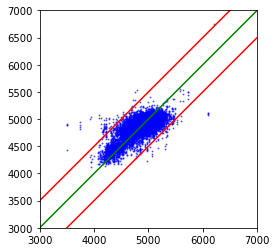

In [38]:
# plt.scatter(train_y,pred_train_y, c='red', alpha=0.5,s=1)

plt.scatter(test_y,pred_test_y, c='blue', alpha=0.5,s=1)

linex = np.linspace(3000, 7000)
liney = linex
lineytop = linex+500
lineybot = linex-500
# Create the plot
plt.plot(linex, liney,c="green")
plt.plot(linex, lineytop,c="red")
plt.plot(linex, lineybot,c="red")


plt.xlim(3000, 7000)
plt.ylim(3000, 7000)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [39]:
def normalize1D(data):
    return np.divide(np.nan_to_num(data,np.nanmean(data)),np.nanmax(data))

In [40]:
mse = np.sqrt(mean_squared_error(normalize1D(test_y),normalize1D(pred_test_y)))
mae = mean_absolute_error(normalize1D(test_y),normalize1D(pred_test_y))
print("Mean Sq. Error, Mean Abs. Error")
print(mse,mae)

Mean Sq. Error, Mean Abs. Error
0.065643884 0.060897335
